## Summary

- 1.线性回归特征处理 => log transformation

- 2.性能验证 => K-fold

- 3.特征选择 => lasso(L1的稀疏性)

- 4.线性与非线性回归 => Tree based Regressions

- 5.调参 => 
    
    1.贪心（一直往最好的子集走，局部最优）； 
    
    2.网格搜索 => 更像是尝试多种参数组合； 
    
    3.贝叶斯调参：贝叶斯优化通过基于目标函数的过去评估结果建立替代函数（概率模型），来找到最小化目标函数的值。贝叶斯方法与随机或网格搜索的不同之处在于，它在尝试下一组超参数时，会参考之前的评估结果，因此可以省去很多无用功。 

1. 线性回归模型：
    - 线性回归对于特征的要求；
    - 处理长尾分布；
    - 理解线性回归模型；
2. 模型性能验证：
    - 评价函数与目标函数；
    - 交叉验证方法；
    - 留一验证方法；
    - 针对时间序列问题的验证；
    - 绘制学习率曲线；
    - 绘制验证曲线；
3. 嵌入式特征选择：
    - Lasso回归；
    - Ridge回归；
    - 决策树；
4. 模型对比：
    - 常用线性模型；
    - 常用非线性模型；
5. 模型调参：
    - 贪心调参方法；
    - 网格调参方法；
    - 贝叶斯调参方法；

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
print(pd.__version__)

1.0.3


reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520303.00 MB
Decreased by 73.4%


In [4]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

In [25]:
sample_feature = sample_feature.dropna().replace('-', 0.).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]
train_X = train[continuous_feature_names]
train_y = train['price']

In [26]:
for i in continuous_feature_names:
    print(i+ ":")
    print(sample_feature[i].describe())
    print("=================================")

SaleID:
count     91729.000000
mean      74849.426288
std       43322.684318
min           0.000000
25%       37246.000000
50%       74864.000000
75%      112379.000000
max      149998.000000
Name: SaleID, dtype: float64
bodyType:
count    91729.0
mean         NaN
std          0.0
min          0.0
25%          0.0
50%          1.0
75%          3.0
max          7.0
Name: bodyType, dtype: float64
fuelType:
count    91729.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          1.0
max          6.0
Name: fuelType, dtype: float64
gearbox:
count    91729.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          1.0
Name: gearbox, dtype: float64
kilometer:
count    91729.0
mean         NaN
std          0.0
min          0.5
25%         10.0
50%         15.0
75%         15.0
max         15.0
Name: kilometer, dtype: float64
name:
count     91729.000000
mean      65291.839353
std       60570.187

## 簡單建模

In [27]:
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [28]:
model = LinearRegression(normalize=True)

In [29]:
model = model.fit(train_X, train_y)

In [30]:
print('intercept:'+ str(model.intercept_))

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:-110670.68277861271


[('v_6', 3367064.341641841),
 ('v_8', 700675.5609398806),
 ('v_9', 170630.27723221338),
 ('v_7', 32322.66193202834),
 ('v_12', 20473.670796906787),
 ('v_3', 17868.07954146547),
 ('v_11', 11474.938996684026),
 ('v_13', 11261.76456000408),
 ('v_10', 2683.9200905680095),
 ('gearbox', 881.8225039246755),
 ('fuelType', 363.9042507214844),
 ('bodyType', 189.60271012073764),
 ('city', 44.94975120522882),
 ('power', 28.553901616754334),
 ('brand_price_median', 0.5103728134079155),
 ('brand_price_std', 0.45036347092633305),
 ('brand_amount', 0.14881120395065783),
 ('brand_price_max', 0.003191018670313686),
 ('SaleID', 5.3559899198549245e-05),
 ('train', 6.404414307326078e-06),
 ('seller', 5.450972821563482e-06),
 ('offerType', 4.499626811593771e-06),
 ('brand_price_sum', -2.1750068681876806e-05),
 ('name', -0.00029800127130837225),
 ('used_time', -0.0025158943328932085),
 ('brand_price_average', -0.40490484510118296),
 ('brand_price_min', -2.2467753486891184),
 ('power_bin', -34.42064411727824)

In [31]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

绘制特征v_9的值与标签的散点图，图片发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大，且部分预测值出现了小于0的情况，说明我们的模型存在一些问题

The predicted price is obvious different from true price


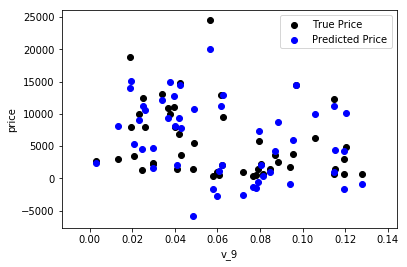

In [38]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

通过作图我们发现数据的标签（price）呈现长尾分布，不利于我们的建模预测。原因是很多模型都假设数据误差项符合正态分布，而长尾分布的数据违背了这一假设。参考博客：https://blog.csdn.net/Noob_daniel/article/details/76087829

It is clear to see the price shows a typical exponential distribution


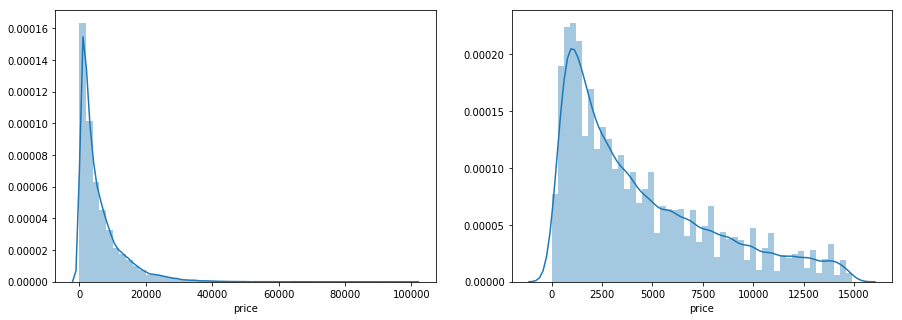

In [33]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

在这里我们对标签进行了 $log(x+1)$ 变换，使标签贴近于正态分布

In [34]:
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


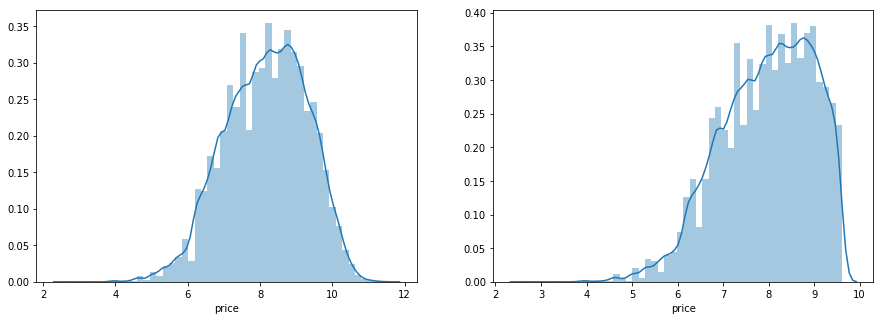

In [35]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [39]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.75074540761262


[('v_9', 8.052411882897355),
 ('v_5', 5.764248312440245),
 ('v_12', 1.6182066821285739),
 ('v_1', 1.4798302891160031),
 ('v_11', 1.1669014617633318),
 ('v_13', 0.9404706048567948),
 ('v_7', 0.7137294893563007),
 ('v_3', 0.6837865348579558),
 ('v_0', 0.00850052812593109),
 ('power_bin', 0.008497967211031536),
 ('gearbox', 0.007922377670831014),
 ('fuelType', 0.006684768364460004),
 ('bodyType', 0.004523520658200924),
 ('power', 0.0007161896138878334),
 ('brand_price_min', 3.334353058972808e-05),
 ('brand_amount', 2.897879991771363e-06),
 ('brand_price_median', 1.2571115079399939e-06),
 ('brand_price_std', 6.659132501043038e-07),
 ('brand_price_max', 6.194957266233421e-07),
 ('brand_price_average', 5.999434780841368e-07),
 ('SaleID', 2.119416207271336e-08),
 ('train', 3.416289473534562e-11),
 ('offerType', -7.053468920048545e-11),
 ('seller', -9.592682204129233e-11),
 ('brand_price_sum', -1.5126510339930958e-10),
 ('name', -7.01551069636076e-08),
 ('used_time', -4.122477174275779e-06),
 

The predicted price seems normal after np.log transforming


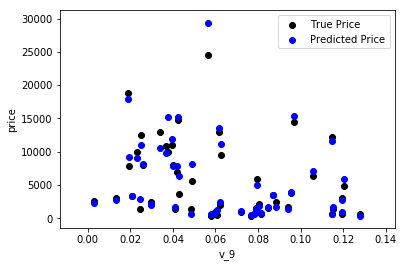

In [40]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

## 五折交叉验证

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [42]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

使用线性回归模型，对未处理标签的特征数据进行五折交叉验证（Error 1.36）

In [43]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


In [44]:
print('AVG:', np.mean(scores))

AVG: 1.3658024027229125


使用线性回归模型，对处理过标签的特征数据进行五折交叉验证（Error 0.19）

In [45]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


In [46]:
print('AVG:', np.mean(scores))

AVG: 0.19325301545987955


In [47]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

cv1       cv2       cv3       cv4       cv5
MAE  0.190792  0.193758  0.194132  0.191825  0.195758

### 模拟真实业务情况

但在事实上，由于我们并不具有预知未来的能力，五折交叉验证在某些与时间相关的数据集上反而反映了不真实的情况。通过2018年的二手车价格预测2017年的二手车价格，这显然是不合理的，因此我们还可以采用时间顺序对数据集进行分隔。在本例中，我们选用靠前时间的4/5样本当作训练集，靠后时间的1/5当作验证集，最终结果与五折交叉验证差距不大

In [48]:
import datetime
sample_feature = sample_feature.reset_index(drop=True)
split_point = len(sample_feature) // 5 * 4

In [49]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [50]:
model = model.fit(train_X, train_y_ln)

In [51]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19577667051816908

### 绘制学习率曲线与验证曲线

In [52]:
from sklearn.model_selection import learning_curve, validation_curve
? learning_curve

In [53]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt     

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

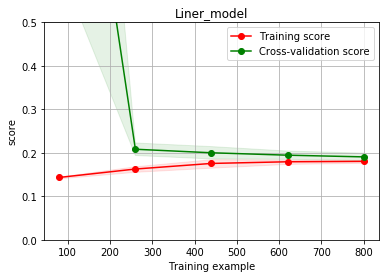

In [54]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

### 多模型比对

In [55]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

### 线性模型 & 嵌入式特征选择

本章节默认，学习者已经了解关于过拟合、模型复杂度、正则化等概念。否则请寻找相关资料或参考如下连接：

  - 用简单易懂的语言描述「过拟合 overfitting」？ https://www.zhihu.com/question/32246256/answer/55320482
  - 模型复杂度与模型的泛化能力 http://yangyingming.com/article/434/
  - 正则化的直观理解 https://blog.csdn.net/jinping_shi/article/details/52433975
  
在过滤式和包裹式特征选择方法中，特征选择过程与学习器训练过程有明显的分别。而嵌入式特征选择在学习器训练过程中自动地进行特征选择。嵌入式选择最常用的是L1正则化与L2正则化。在对线性回归模型加入两种正则化方法后，他们分别变成了岭回归与Lasso回归。

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [58]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [59]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [60]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

LinearRegression     Ridge     Lasso
cv1          0.190792  0.194832  0.383899
cv2          0.193758  0.197632  0.381893
cv3          0.194132  0.198123  0.384090
cv4          0.191825  0.195670  0.380526
cv5          0.195758  0.199676  0.383611

intercept:8.672182395965754


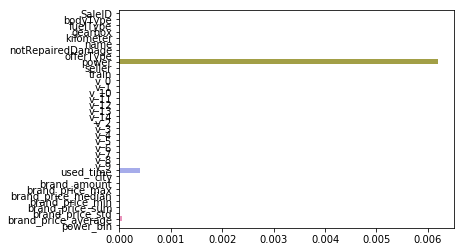

In [75]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

L2正则化在拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型。因为一般认为参数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。可以设想一下对于一个线性回归方程，若参数很大，那么只要数据偏移一点点，就会对结果造成很大的影响；但如果参数足够小，数据偏移得多一点也不会对结果造成什么影响，专业一点的说法是『抗扰动能力强』

除此之外，决策树通过信息熵或GINI指数选择分裂节点时，优先选择的分裂特征也更加重要，这同样是一种特征选择的方法。XGBoost与LightGBM模型中的model_importance指标正是基于此计算的

intercept:4.671710782172461


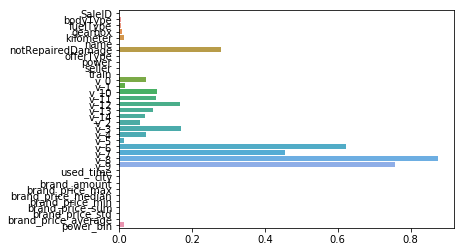

In [63]:
# L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择。如下图，我们发现power与userd_time特征非常重要。
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:18.750745410681283


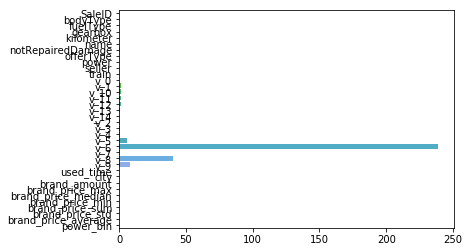

In [65]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

## 非线性模型

除了线性模型以外，还有许多我们常用的非线性模型如下，在此篇幅有限不再一一讲解原理。我们选择了部分常用模型与线性模型进行效果比对。

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [69]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

In [70]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
LGBMRegressor is finished


In [76]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

LinearRegression  DecisionTreeRegressor  RandomForestRegressor  \
cv1          0.190792               0.197860               0.132825   
cv2          0.193758               0.193157               0.134458   
cv3          0.194132               0.190578               0.133718   
cv4          0.191825               0.188980               0.132568   
cv5          0.195758               0.205462               0.137255   

     GradientBoostingRegressor  MLPRegressor  XGBRegressor  LGBMRegressor  
cv1                   0.168897    426.719396      0.142333       0.141546  
cv2                   0.171850    148.423853      0.140987       0.145501  
cv3                   0.170935    501.234487      0.139266       0.143887  
cv4                   0.169076    525.301499      0.137399       0.142497  
cv5                   0.174094    443.735973      0.143998       0.144852

##  模型调参

在此我们介绍了三种常用的调参方法如下：

  - 贪心算法 https://www.jianshu.com/p/ab89df9759c8
  - 网格调参 https://blog.csdn.net/weixin_43172660/article/details/83032029
  - 贝叶斯调参 https://blog.csdn.net/linxid/article/details/81189154

In [77]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

### 1.贪心调参

In [78]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

In [88]:
best_obj

{'regression': 0.14365642954291205,
 'regression_l1': 0.142368724489429,
 'mape': 0.14311170237651907,
 'huber': 0.14289213113490867,
 'fair': 0.1438883270460827}

In [85]:
best_leaves

{3: 0.19795713713539834,
 5: 0.17956652668791057,
 10: 0.16034687276450937,
 15: 0.1528650955465937,
 20: 0.14816575342241883,
 40: 0.13904257813072585,
 55: 0.13577653962518615}

In [87]:
best_depth

{3: 0.17451384696732963,
 5: 0.14939265234034801,
 10: 0.13586880544143973,
 15: 0.13573644788688818,
 20: 0.13566813140530445,
 40: 0.13577653962518615,
 55: 0.13577653962518615}

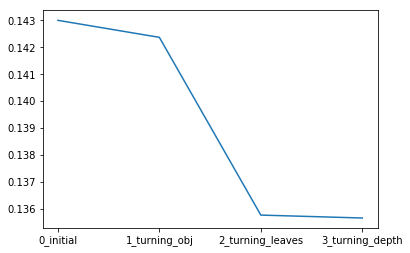

In [79]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

### 2.Grid Search 调参

In [73]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [ ]:
clf.best_params_

In [ ]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)

In [ ]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

### 3.贝叶斯调参

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [ ]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [ ]:
rf_bo.maximize()